## 1. Backscatter - remote sensing in the ocean
<p><img align="right" width="400" height="1000" src="https://assets.datacamp.com/production/project_547/img/4167340394_cc0b979fac_b_crop.jpg"> 
Reflections. No, I’m not talking about contemplating your existence within the Tidyverse or understanding
what that spline did to your data. I’m talking about echoes. Specifically, acoustic echoes called “backscatter.” Marine scientists use acoustic backscatter to understand the distribution of organisms in the ocean.</p>
<p>In this analysis, we are going to wrangle active acoustic data and plot the mean volume backscatter associated with fish with swim-bladders in relation to bathymetry (depth of the seafloor).</p>
<p>These acoustic data were collected from a research vessel that crossed the shelf break in the Mid-Atlantic Bight (<a href="https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ngdc.mgg.wcd:HB1103_EK60">NOAA cruise HB1103</a>) and were preprocessed using the software, <a href="https://www.echoview.com/">Echoview</a>.</p>

In [24]:
# Load the libraries
library(dplyr)
library(readr)
library(lubridate)
library(ggplot2)
library(patchwork)

# Read in the depth data
bottom <- read_csv("datasets/bottom_line.csv", 
                   col_types = cols(Ping_date = col_datetime(format = "%m/%d/%Y"))) %>% 
          rename_all(tolower)

# Glimpse the data
glimpse(bottom)

Observations: 2,766
Variables: 10
$ ping_date         <dttm> 2011-06-18, 2011-06-18, 2011-06-18, 2011-06-18, ...
$ ping_time         <time> 09:53:37, 09:53:42, 09:58:47, 09:58:52, 09:58:57...
$ ping_milliseconds <dbl> 725, 741, 866, 866, 866, 866, 882, 882, 882, 882,...
$ latitude          <dbl> 999.00000, 38.29771, 38.29429, 38.29424, 38.29418...
$ longitude         <dbl> 999.00000, -74.00185, -73.99677, -73.99666, -73.9...
$ position_status   <dbl> 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...
$ depth             <dbl> 68.60377, 68.60024, 68.78515, 68.77859, 68.37986,...
$ line_status       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...
$ ping_status       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...
$ altitude          <dbl> -9.9e+37, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0...


## 2. What is the "shelf break"?
<p><img align="left" width="400" height="1000" src="https://assets.datacamp.com/production/project_547/img/map_trkln.png"></p>
<p>The red line in the map to the left is the ship’s track across the shelf break in the Mid-Atlantic Bight. But what is the “shelf break”? It’s the underwater version of a cliff. </p>
<p>In most marine ecosystems, the shelf break is also a highly dynamic and productive area that provides food and habitat for many species. From the smallest phytoplankton to the largest marine mammals, sharks, seabirds, tunas, and sea turtles - they all use this area at some point in their life cycles. And, we’re going to play with some active acoustic data from this fantastic region!</p>
<p>But first, let’s clean up the bathymetry (depth) data and get it ready for plotting. </p>

In [26]:
# Clean the bottom data
bottom_clean <- bottom %>%
  filter(position_status == 1) %>%
  select(c(ping_date, ping_time, latitude, longitude, depth)) %>%
  mutate(date_time = ping_date + ping_time,
       distance_between = c(0, 
                            geosphere::distHaversine(cbind(longitude[-n()], latitude[-n()]),
                                                     cbind(longitude[ -1], latitude[ -1]))),                         
       distance_along = cumsum(distance_between))
  
# Inspect the data
glimpse(bottom_clean)

Observations: 2,764
Variables: 8
$ ping_date        <dttm> 2011-06-18, 2011-06-18, 2011-06-18, 2011-06-18, 2...
$ ping_time        <time> 09:58:47, 09:58:52, 09:58:57, 09:59:02, 09:59:07,...
$ latitude         <dbl> 38.29429, 38.29424, 38.29418, 38.29411, 38.29404, ...
$ longitude        <dbl> -73.99677, -73.99666, -73.99653, -73.99641, -73.99...
$ depth            <dbl> 68.78515, 68.77859, 68.37986, 68.37986, 68.37986, ...
$ date_time        <dttm> 2011-06-18 09:58:47, 2011-06-18 09:58:52, 2011-06...
$ distance_between <dbl> 0.00000, 11.47956, 12.77948, 13.24406, 14.17050, 1...
$ distance_along   <dbl> 0.00000, 11.47956, 24.25904, 37.50310, 51.67360, 6...


## 3. Where ever you go, there you are
<p>Now that we have removed the bad data points and calculated the cumulative distance the ship traveled, let's plot the data. </p>
<p>A horizontal view of the ship's track will show us if the ship deviated from the track line or if there were any breaks in the data. </p>
<p>A plot of the depth of the seafloor along the track line will show us the position of the shelf break. In a spatial analysis of the track line data, we would typically work in the packages <code>sp</code> and <code>sf</code>, but that's a topic all its own. For now, we'll create a couple of track line plots with the latitude, longitude, depth, and distance along the track line.</p>

$x
[1] "Longitude"

$y
[1] "Latitude"

attr(,"class")
[1] "labels"

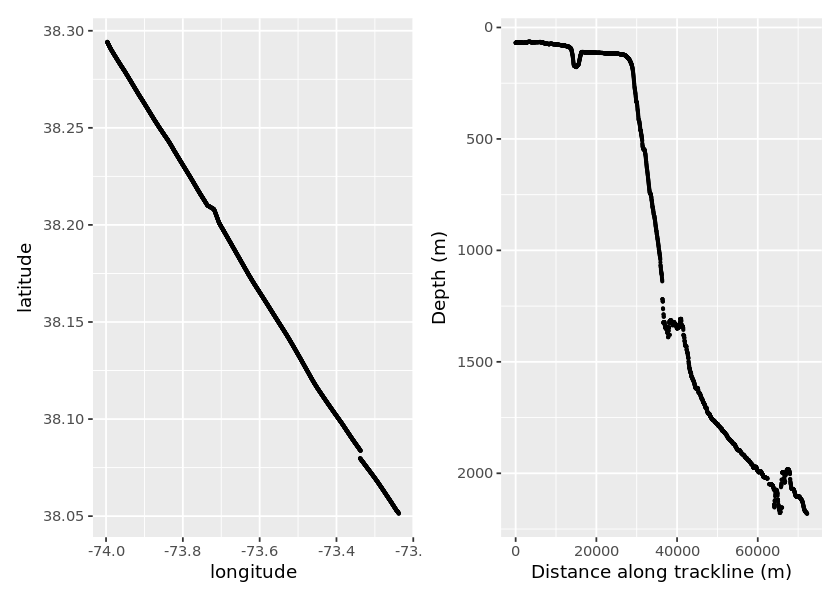

In [28]:
# Reduce the size of the plots
options(repr.plot.width = 7, repr.plot.height = 5)

# Plot the ship's track
p_ship_track  <- ggplot(bottom_clean, aes(x=longitude, y=latitude)) +
  geom_point(size = 0.5)
  labs(x = "Longitude", y = "Latitude")

# Plot the depth of the sea floor along the ship's track
p_bathymetry  <-  ggplot(bottom_clean, aes(x=distance_along, y=depth)) +
  geom_point(size = 0.5) + 
  scale_y_reverse() + 
  labs(x = "Distance along trackline (m)", y = "Depth (m)")

# Arrange the plots side by side for easier viewing
p_ship_track + p_bathymetry

## 4. Here fishy, fishy, fishy...
<p>Volume backscatter (Sv) is a measure of the relative density of organisms. In this case, because we preprocessed the data in <a href="https://www.echoview.com/">Echoview</a> to look for fish-like scattering, our final plot of the volume backscatter data, <code>Sv_mean</code>, will give us an indication of the distribution of fish along the track line.</p>
<p>Will there be sections of the track line with higher/lower densities if fish? Let's find out!</p>

In [30]:
# Read in the acoustic data
acoustic <- read_csv("datasets/acoustic.csv", 
                 col_types = cols(Date_M = col_datetime(format = "%Y%m%d")))  %>% 
  filter(Lon_M != 999.0)

# Glimpse the data
glimpse(acoustic)

Observations: 724
Variables: 78
$ Process_ID                           <dbl> 20216, 20216, 20216, 20216, 20...
$ Interval                             <dbl> 4, 5, 6, 7, 8, 9, 10, 11, 12, ...
$ Layer                                <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ Sv_mean                              <dbl> -67.97805, -67.65053, -66.6586...
$ NASC                                 <dbl> 365.6001, 429.4046, 539.5769, ...
$ Sv_max                               <dbl> -53.93325, -54.51390, -51.3186...
$ Sv_min                               <dbl> -88.67275, -87.36100, -88.9946...
$ Sv_noise                             <dbl> -967.8684, -967.6432, -967.623...
$ NASC_noise                           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ Height_mean                          <dbl> 53.25000, 58.00000, 58.00000, ...
$ Depth_mean                           <dbl> 39.04617, 39.00000, 39.00000, ...
$ Good_samples                         <dbl> 639, 522, 464, 464, 406, 464, ...
$ Layer_depth_min   

## 5. That's a lot of variables!
<p><strong>Wow! 724 observations of 78 variables!</strong> This is the full data export from Echoview, but remember, we’re only interested in the volume backscatter data, <code>Sv_mean</code>, and the few other variables needed to plot the data. </p>
<p>These backscatter data were integrated into grid cells that are 200 meters along the ship’s path (numbered in the variable, <code>Interval</code>), by 250 meters deep, (numbered in the variable, <code>Layer</code>), making a coordinate system referenced to the ship’s path and depth. We are going to explore the first depth layer.</p>

In [32]:
# Create a list of variables to keep
variables_keep <- c("Interval", "Layer", "Sv_mean", "Frequency", 
               "Date_M", "Time_S", "Time_E", "Lat_M", "Lon_M")

# Select, rename, filter, mutate, and arrange the data 
Sv_layer1 <- acoustic %>%
    select(one_of(variables_keep)) %>% 
    rename(Spatial_interval = Interval, Date = Date_M) %>%
    filter(Layer == 1)  %>% 
    mutate(Datetime_start = Date + Time_S,
         Datetime_end = Date + Time_E)  %>% 
    arrange(Datetime_start) 

# Glimpse the cleaned acoustic data
glimpse(Sv_layer1)

Observations: 362
Variables: 11
$ Spatial_interval <dbl> 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
$ Layer            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ Sv_mean          <dbl> -67.97805, -67.65053, -66.65866, -68.24425, -69.02...
$ Frequency        <dbl> 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38...
$ Date             <dttm> 2011-06-18, 2011-06-18, 2011-06-18, 2011-06-18, 2...
$ Time_S           <time> 09:58:47, 09:59:47, 10:00:32, 10:01:12, 10:01:52,...
$ Time_E           <time> 09:59:42, 10:00:27, 10:01:07, 10:01:47, 10:02:22,...
$ Lat_M            <dbl> 38.29396, 38.29309, 38.29230, 38.29147, 38.29067, ...
$ Lon_M            <dbl> -73.99612, -73.99397, -73.99202, -73.98992, -73.98...
$ Datetime_start   <dttm> 2011-06-18 09:58:47, 2011-06-18 09:59:47, 2011-06...
$ Datetime_end     <dttm> 2011-06-18 09:59:42, 2011-06-18 10:00:27, 2011-06...


## 6. A little more wrangling
<p>Great! All this is coming together nicely. In <code>bottom_clean</code> we have depth, distance along the track line, and timestamps. We now also have an almost clean acoustic dataset, <code>Sv_layer1</code>, with timestamps but no distance along the track line, and no depth information (we'll get to that in a minute). Also, <a href="https://www.echoview.com/">Echoview</a> uses -999.0 to indicate NAs. We need to remove those or our plot of backscatter will look a little wonky. </p>

In [34]:
# More data wrangling...
Sv <- Sv_layer1 %>% 
  mutate(Distance_between = c(0, geosphere::distHaversine(cbind(Lon_M[-n()], Lat_M[-n()]),       
                                               cbind(Lon_M[  -1], Lat_M[  -1]))),
       Distance_along = cumsum(Distance_between)) %>%
  na_if(-999.0) %>% 
  mutate(Time_interval = interval(Datetime_start, Datetime_end))

# Glimpse the data
glimpse(Sv)

Observations: 362
Variables: 14
$ Spatial_interval <dbl> 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
$ Layer            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ Sv_mean          <dbl> -67.97805, -67.65053, -66.65866, -68.24425, -69.02...
$ Frequency        <dbl> 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38...
$ Date             <dttm> 2011-06-18, 2011-06-18, 2011-06-18, 2011-06-18, 2...
$ Time_S           <time> 09:58:47, 09:59:47, 10:00:32, 10:01:12, 10:01:52,...
$ Time_E           <time> 09:59:42, 10:00:27, 10:01:07, 10:01:47, 10:02:22,...
$ Lat_M            <dbl> 38.29396, 38.29309, 38.29230, 38.29147, 38.29067, ...
$ Lon_M            <dbl> -73.99612, -73.99397, -73.99202, -73.98992, -73.98...
$ Datetime_start   <dttm> 2011-06-18 09:58:47, 2011-06-18 09:59:47, 2011-06...
$ Datetime_end     <dttm> 2011-06-18 09:59:42, 2011-06-18 10:00:27, 2011-06...
$ Distance_between <dbl> 0.0000, 211.7871, 192.3324, 204.8778, 209.1278, 18...
$ Distance_along   <

## 7. Can't go spatial? Go temporal
<p>There is no depth information in the acoustic file. Well, that's not exactly true. One of those 78 variables was a mean depth, but it was an average of an average, and it was not as accurate as the depth data we have in <code>bottom_clean</code>. </p>
<p>You might have also noticed that the two data sets have different spatial resolutions. How can we pull the depth data out of <code>bottom_clean</code> and join it with the acoustic data? There are a few different spatial ways to do this, but because we are not working in the spatial packages, we'll write a function to figure out which data points from <code>bottom_clean</code> fall <em>within</em> the time interval, <code>Time_interval</code>, we just created.</p>

In [36]:
# Function: assign Spatial_interval to bottom points that fall within Time_interval
get_Interval_by_time <- function(bottom_data){
  res <- Sv$Spatial_interval[bottom_data %within% Sv$Time_interval]
  if(length(res)==0) return(NA)         
  return(res)
}
 
# Map the track line interval value to bottom_clean
bottom_spatial_interval_segments <- bottom_clean  %>% 
    mutate(trackline_interval = purrr::map_dbl(date_time, get_Interval_by_time))

# Inspect the first 15 rows
head(bottom_spatial_interval_segments, 15)

ping_date,ping_time,latitude,longitude,depth,date_time,distance_between,distance_along,trackline_interval
<dttm>,<time>,<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>
2011-06-18,09:58:47,38.29429,-73.99677,68.78515,2011-06-18 09:58:47,0.00000,0.00000,4
2011-06-18,09:58:52,38.29424,-73.99666,68.77859,2011-06-18 09:58:52,11.47956,11.47956,4
2011-06-18,09:58:57,38.29418,-73.99653,68.37986,2011-06-18 09:58:57,12.77948,24.25904,4
2011-06-18,09:59:02,38.29411,-73.99641,68.37986,2011-06-18 09:59:02,13.24406,37.50310,4
2011-06-18,09:59:07,38.29404,-73.99627,68.37986,2011-06-18 09:59:07,14.17050,51.67360,4
2011-06-18,09:59:12,38.29396,-73.99612,68.38039,2011-06-18 09:59:12,15.34577,67.01937,4
2011-06-18,09:59:17,38.29390,-73.99597,68.38039,2011-06-18 09:59:17,15.09648,82.11585,4
2011-06-18,09:59:22,38.29383,-73.99582,68.37777,2011-06-18 09:59:22,15.72843,97.84428,4
2011-06-18,09:59:27,38.29375,-73.99564,68.37777,2011-06-18 09:59:27,18.05774,115.90203,4


## 8. Depth of an Interval
<p>Now that we have spatial track line intervals from the acoustic data assigned to each data point in <code>bottom_spatial_interval_segments</code>, we can calculate the mean depth for each <code>trackline_interval</code> along the track line. Then we'll need to join the two datasets on the <code>Spatial_interval</code> and <code>trackline_interval</code>. </p>
<p>Remember that we're only looking at the first depth layer (0 to 250 m). Because we do not want to insinuate that we're plotting data integrated over the entire water column, we will replace depths greater than 250 m with 250.</p>

In [41]:
# Group bottom_clean and calculate the mean depth
bottom_intervals <- bottom_spatial_interval_segments %>%
    group_by(trackline_interval) %>%
    summarise(depth_mean = mean(depth)) %>%
    ungroup()

# Join the bottom intervals data to the acoustic data
Sv_and_depth <- Sv %>%
  left_join(bottom_intervals, by = c("Spatial_interval" = "trackline_interval")) %>%
  mutate(depth_plot = ifelse(depth_mean >= 250, 250, depth_mean))

# Glimpse the data 
glimpse(Sv_and_depth)

Observations: 362
Variables: 16
$ Spatial_interval <dbl> 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
$ Layer            <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...
$ Sv_mean          <dbl> -67.97805, -67.65053, -66.65866, -68.24425, -69.02...
$ Frequency        <dbl> 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38...
$ Date             <dttm> 2011-06-18, 2011-06-18, 2011-06-18, 2011-06-18, 2...
$ Time_S           <time> 09:58:47, 09:59:47, 10:00:32, 10:01:12, 10:01:52,...
$ Time_E           <time> 09:59:42, 10:00:27, 10:01:07, 10:01:47, 10:02:22,...
$ Lat_M            <dbl> 38.29396, 38.29309, 38.29230, 38.29147, 38.29067, ...
$ Lon_M            <dbl> -73.99612, -73.99397, -73.99202, -73.98992, -73.98...
$ Datetime_start   <dttm> 2011-06-18 09:58:47, 2011-06-18 09:59:47, 2011-06...
$ Datetime_end     <dttm> 2011-06-18 09:59:42, 2011-06-18 10:00:27, 2011-06...
$ Distance_between <dbl> 0.0000, 211.7871, 192.3324, 204.8778, 209.1278, 18...
$ Distance_along   <

## 9. Putting it all together
<p>Woohoo! We have done a lot of data wrangling! </p>
<p>Now it's time to plot <code>Sv_mean</code> in relation to the bathymetry (<code>depth_plot</code>) to find out where the high and low densities of fishes are along the track line. Because our y-axes are on two different scales, we'll create two plots and use the <code>patchwork</code> package again to put them in one figure.</p>

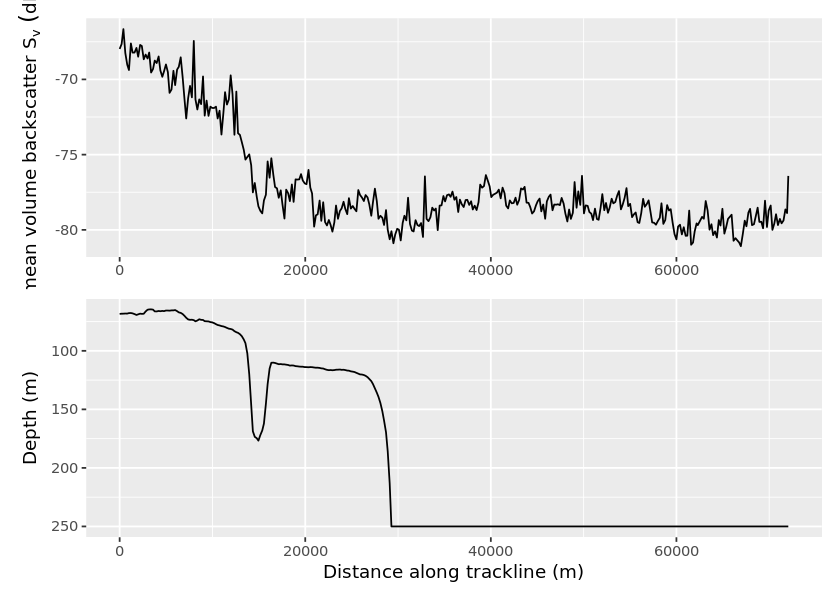

In [44]:
# Top panel
Sv_mean_plot <- ggplot(Sv_and_depth, aes(x=Distance_along, y=Sv_mean)) +
  geom_line() +
  labs(y=expression(mean~volume~backscatter~S[v]~(dB))) +
  theme(axis.title.x=element_blank())

# Bottom panel
bathymetry <- ggplot(Sv_and_depth, aes(x=Distance_along, y=depth_plot)) +
  geom_line(size = 0.5) +
  scale_y_reverse() +
  labs(x = "Distance along trackline (m)", y = "Depth (m)")

# Display the two panels in one figure
Sv_mean_plot / bathymetry

## 10. So, where are the fishes?
<p>Nice looking plot!</p>
<p>If we assume that all the acoustic backscatter is only from fishes with swim bladders, and greater backscatter indicates higher densities of fish, where are most of the fish on this track line?</p>

In [45]:
# Where do you think the fish are along this track line?

# Options: Shelf, Shelf Break, Offshore

(where_are_the_fishes <- "Shelf")

[1] "Shelf"